In [96]:
import numpy as np
from warnings import warn


def fbm(n, H=0.5, L=1, method="daviesharte", random_seed=None):
    methods = {'daviesharte': daviesharte
               }

    if random_seed is not None:
	    np.random.seed(random_seed)
			   
    try:
        fbm_realization = methods[method]
    except KeyError:
        raise ValueError('Method must be \'daviesharte\', \'hosking\' or \
                    \'cholesky\'')

    return fbm_realization(n, H, L)


def autocovariance(H, k):
    return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) +
                  abs(k + 1) ** (2 * H))


def daviesharte(n, H=0.5, L=1):
    increment = float(L) / n
    scale = increment ** H
    fgn = np.random.normal(0.0, 1.0, n)
    B = fgn
    if H == 0.5:
        pass
    else:
        row_component = [autocovariance(H, i) for i in range(1, n)]
        reverse_component = [row_component[-i] for i in range(1, n)]
        row = [autocovariance(H, 0)] + row_component + [0] + reverse_component
        eigenvals = np.fft.fft(row).real
        fgn2 = np.random.normal(0.0, 1.0, n)
        w = np.zeros(2 * n, dtype=complex)
        for i in range(2 * n):
            if i == 0:
                w[i] = np.sqrt(eigenvals[i] / (2 * n)) * fgn[i]
            elif i < n:
                w[i] = np.sqrt(eigenvals[i] / (4 * n)) * \
                    (fgn[i] + 1j * fgn2[i])
            elif i == n:
                w[i] = np.sqrt(eigenvals[i] / (2 * n)) * fgn2[0]
            else:
                w[i] = np.sqrt(eigenvals[i] / (4 * n)) * \
                    (fgn[2 * n - i] - 1j * fgn2[2 * n - i])
        z = np.fft.fft(w)
        fgn = z[:n].real
    fgn *= scale
    fbm = fgn.cumsum()
    fbm = np.insert(fbm, [0], 0)
    t = np.linspace(0, L, n + 1)
    return fgn, B

In [97]:
# parameter & fgn sample
T = 5
tpd = 60*8
N = round(tpd*250*T)
H = 0.6
fgn_seed = 20
fgn,B = fbm(n=N, H=H, L=T, method='daviesharte',random_seed=fgn_seed)

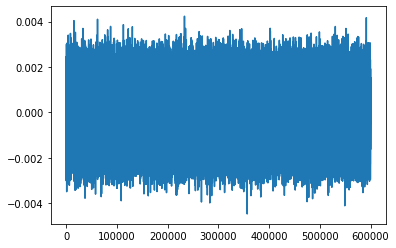

In [98]:
import matplotlib.pyplot as plt
plt.plot(fgn)

In [99]:
import numpy as np
def sim_vol(T,eta,xi0,alpha,H,fgn):
    n = len(fgn)
    dt = T/n
    fou = [xi0]
    for i in range(n-1):
        fou.append(fou[i]+eta*fgn[i+1]*(dt**H)+alpha*(xi0-fou[i])*dt)
    return np.sqrt(np.exp(fou))

In [100]:
eta = 2.5
xi0 = -3.2
alpha = 0.005
vol = sim_vol(T,eta,xi0,alpha,H,fgn)

In [101]:
def sim_price(S0,T,vol,rho,B,price_seed):
    np.random.seed(price_seed)
    n = len(B)
    W = np.random.randn(n)
    Z = rho*B+np.sqrt(1-rho**2)*W
    dt = T/n
    prices = [S0]
    for i in range(n-1):
        prices.append(prices[i]*np.exp(vol[i+1]*W[i]*np.sqrt(dt)-0.5*vol[i+1]**2*dt))
    return prices

In [102]:
S0 = 100
rho = -0.9
price_seed = 10
ticks = sim_price(S0,T,vol,rho,B,price_seed)

Text(0, 0.5, '$\\sigma$')

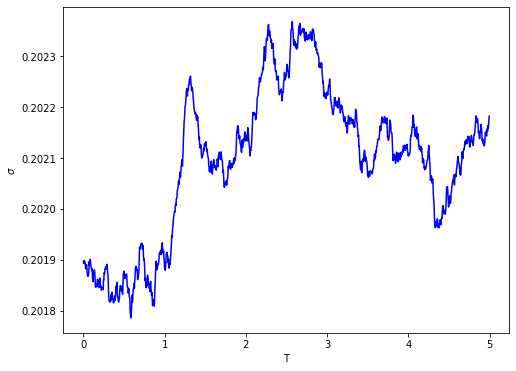

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(vol[::tpd]))/250,vol[::tpd],color='blue')
plt.xlabel('T')
plt.ylabel('$\sigma$')

Text(0, 0.5, 'S')

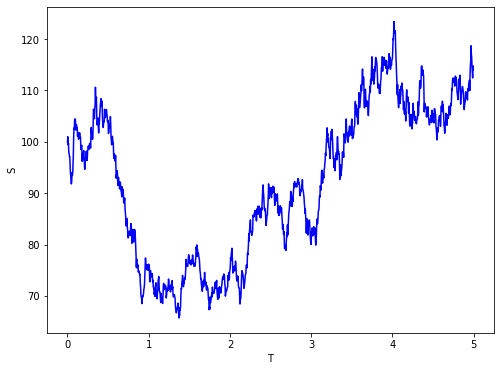

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(ticks[::tpd]))/250,ticks[::tpd],color="blue")
plt.xlabel('T')
plt.ylabel('S')

In [105]:
import pandas as pds
def rvol(ticks,seconds,tpd):
    ticks = ticks[::seconds]
    ticks = pds.DataFrame(ticks,columns=['ticks'])
    log_prices = (abs((np.log(ticks)-np.log(ticks.shift(1))).dropna())**2)
    log_prices = log_prices.to_numpy()
    rv_np = []
    for i in range(round(len(log_prices)/tpd)-1):
        rv_np.append(sum(log_prices[tpd*i:tpd*(i+1)]))
    return np.sqrt(rv_np)

In [106]:
def hurst(rv_np):
    rv = pds.DataFrame(rv_np,columns=['rv'])
    qs = np.array([0.25,0.5,1,1.5,2,3])
    deltas = np.arange(1,101)
    hq = []
    for q in qs:
        mq = []
        for delta in deltas:
            mq.append(np.mean(abs(((np.log(rv)-np.log(rv).shift(delta)).dropna()))**q))
        y = np.polyfit(np.log(deltas),np.log(mq),deg=1)
        hq.append(y[0])
    h = np.polyfit(qs,hq,deg=1)
    return h[0]

In [109]:
# rv 1 minute interval
rv1 = rvol(ticks,1,tpd)
h1 = hurst(rv1)
print(str(h1))

[0.00136305]


In [108]:
# rv 5 minute interval
rv5 = rvol(ticks,5,round(tpd/5))
h5 = hurst(rv5)
print(str(h5))

[-0.00038197]


In [111]:
# simulated volatility process
h_vol = hurst(vol)
print(h_vol)

[0.59706483]


Text(0, 0.5, '$\\sigma$')

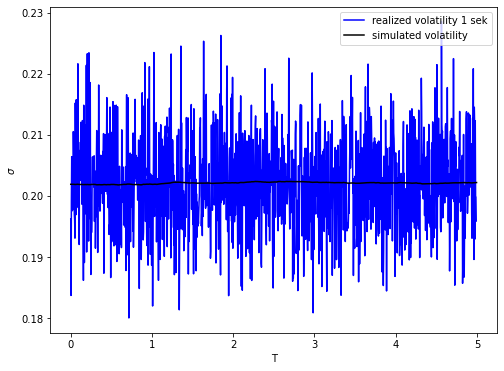

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(rv))/250,rv*np.sqrt(250),label='realized volatility 1 sek',color='blue')
plt.plot(np.arange(len(vol[::tpd]))/250,vol[::tpd],label='simulated volatility',color='black')
plt.legend()
plt.xlabel('T')
plt.ylabel('$\sigma$')

In [ ]:
def hurst_alt(rv):
    qs = np.array([0.25,0.5,1,1.5,2,3])
    deltas = np.arange(1,20,5)
    hq = []
    for q in qs:
        mq = []
        for delta in deltas:
            mq.append(np.mean(abs(((np.log(rv)-np.log(rv).shift(delta)).dropna()))**q))
        y = np.polyfit(np.log(deltas),np.log(mq),deg=1)
        hq.append(y[0])
    h = np.polyfit(qs,hq,deg=1)
    return h,hq

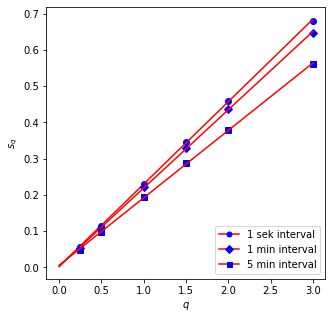

In [ ]:
import matplotlib.lines as mlines
import pandas as pds
rv1_label = mlines.Line2D([], [], color='red', marker='o',markeredgecolor='b',markerfacecolor='b',markersize=5, label='1 sek interval')
rv5_label = mlines.Line2D([], [], color='red', marker='D',markeredgecolor='b',markerfacecolor='b',markersize=5, label='1 min interval')
rv10_label = mlines.Line2D([], [], color='red', marker='s',markeredgecolor='b',markerfacecolor='b',markersize=5, label='5 min interval')
qs = np.array([0.25,0.5,1,1.5,2,3])
x = np.linspace(0, 3, 100)
plt.figure(figsize=(5, 5))
plt.xlabel('$q$')
plt.ylabel('$s_q$')
rv_df = pds.DataFrame(rv,columns=['rv'])
h1,hq1 = hurst_alt(rv_df)
plt.plot(qs,hq1,'o',color='b')
plt.plot(x,h1[0]*x+h1[1],'-',color='r')
rv1_df = pds.DataFrame(rv1,columns=['rv'])
h5,hq5 = hurst_alt(rv1_df)
plt.plot(qs,hq5,'D',color='b')
plt.plot(x,h5[0]*x+h5[1],'-',color='r')
rv5_df = pds.DataFrame(rv5,columns=['rv'])
h10,hq10 = hurst_alt(rv5_df)
plt.plot(qs,hq10,'s',color='b')
plt.plot(x,h10[0]*x+h10[1],'-',color='r')
plt.legend(handles=[rv1_label,rv5_label,rv10_label],loc ="lower right")

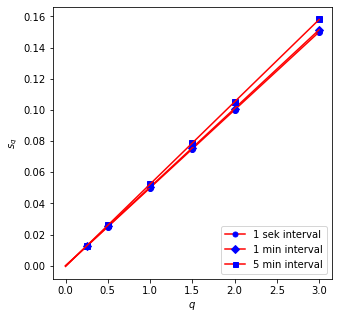

In [ ]:
import matplotlib.lines as mlines
import pandas as pds
rv1_label = mlines.Line2D([], [], color='red', marker='o',markeredgecolor='b',markerfacecolor='b',markersize=5, label='1 sek interval')
rv5_label = mlines.Line2D([], [], color='red', marker='D',markeredgecolor='b',markerfacecolor='b',markersize=5, label='1 min interval')
rv10_label = mlines.Line2D([], [], color='red', marker='s',markeredgecolor='b',markerfacecolor='b',markersize=5, label='5 min interval')
qs = np.array([0.25,0.5,1,1.5,2,3])
x = np.linspace(0, 3, 100)
plt.figure(figsize=(5, 5))
plt.xlabel('$q$')
plt.ylabel('$s_q$')
rv_df = pds.DataFrame(vol,columns=['rv'])
h1,hq1 = hurst_alt(rv_df)
plt.plot(qs,hq1,'o',color='b')
plt.plot(x,h1[0]*x+h1[1],'-',color='r')
rv1_df = pds.DataFrame(vol[::60],columns=['rv'])
h5,hq5 = hurst_alt(rv1_df)
plt.plot(qs,hq5,'D',color='b')
plt.plot(x,h5[0]*x+h5[1],'-',color='r')
rv5_df = pds.DataFrame(vol[::60*5],columns=['rv'])
h10,hq10 = hurst_alt(rv5_df)
plt.plot(qs,hq10,'s',color='b')
plt.plot(x,h10[0]*x+h10[1],'-',color='r')
plt.legend(handles=[rv1_label,rv5_label,rv10_label],loc ="lower right")